 **Problem Statement**::

Emergency vs Non-Emergency Vehicle Classification
Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services.

In this problem, you will be working on classifying vehicle images as either belonging to the emergency vehicle or non-emergency vehicle category. For the same, you are provided with the train and the test dataset. Emergency vehicles usually includes police cars, ambulance and fire brigades.

[Hackathon Link](https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/#About)

# Packages and Data Access

In [ ]:
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating Folders

In [ ]:
os.makedirs('/content/drive/My Drive/AV_CV')

In [ ]:
!unzip '/content/drive/My Drive/AV_CV/train_SOaYf6m.zip' -d '/content/drive/My Drive/AV_CV'

Archive:  /content/drive/My Drive/AV_CV/train_SOaYf6m.zip
   creating: /content/drive/My Drive/AV_CV2/images/
  inflating: /content/drive/My Drive/AV_CV2/images/0.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/10.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/100.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1000.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1001.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1002.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1003.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1004.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1005.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1006.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1007.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1008.jpg  
  inflating: /content/drive/My Drive/AV_CV2/images/1009.jpg  
  inflating: /content/drive/My 

In [ ]:
train_df= pd.read_csv('/content/drive/My Drive/AV_CV2/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/AV_CV/test_vc2kHdQ(1).csv')

In [ ]:
# Creating the folders for images
os.makedirs('/content/drive/My Drive/AV_CV/train')
os.makedirs('/content/drive/My Drive/AV_CV/train/emergency')
os.makedirs('/content/drive/My Drive/AV_CV/train/non_emergency')
os.makedirs('/content/drive/My Drive/AV_CV/test')
os.makedirs('/content/drive/My Drive/AV_CV/test/test')

os.makedirs('/content/drive/My Drive/AV_CV/valid')
os.makedirs('/content/drive/My Drive/AV_CV/valid/emergency')
os.makedirs('/content/drive/My Drive/AV_CV/valid/non_emergency')

In [ ]:
train_base_dir = '/content/drive/My Drive/AV_CV2/train/'
valid_base_dir = '/content/drive/My Drive/AV_CV2/valid/'
test_dir = '/content/drive/My Drive/AV_CV2/test/'
image_dir = '/content/drive/My Drive/AV_CV2/images/'

In [ ]:
# Creating separate sub-folders for emergency and non-emergency vehicles
files = os.listdir(image_dir)
emergency_dir = f"{train_base_dir}emergency"
non_emergency_dir = f"{train_base_dir}non_emergency"

To separate out images, we will rely on the train.csv file and separate out the images accordingly.

Also, the images folder contains the test images also. We separate them out too test folder.

In [ ]:
def create_training_data(df):
    for ind in range(0,len(df)):
      if df['emergency_or_not'].iloc[ind] == 1:
        shutil.move(f'{image_dir}{df["image_names"].iloc[ind]}', emergency_dir)
      elif df['emergency_or_not'].iloc[ind] == 0:
        shutil.move(f'{image_dir}{df["image_names"].iloc[ind]}', non_emergency_dir)

def create_test_data(df):
    for ind in range(0,len(df)):
        shutil.move(f'{image_dir}{df["image_names"].iloc[ind]}', f"{test_dir}test")

In [ ]:
create_training_data(train_df)

In [ ]:
create_test_data(test_df)

## Moving the Data in Validation Directory
To separate out images for training and validation

In [ ]:
for f in os.listdir(emergency_dir):
    if random.random() > 0.80:
        shutil.move(f'{emergency_dir}/{f}', f"{valid_base_dir}emergency")

for f in os.listdir(non_emergency_dir):
    if random.random() > 0.80:
        shutil.move(f'{non_emergency_dir}/{f}', f"{valid_base_dir}non_emergency")

# Pre-processing

In [ ]:
print("Train dataset size: ", train_df.shape)
train_df.head(3)

The total number of training data:  (1646, 2)


In [ ]:
print("Test dataset size: ", test_df.shape)
test_df.head(3)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB


There are no missing values in the dataset.

0    0.58627
1    0.41373
Name: emergency_or_not, dtype: float64

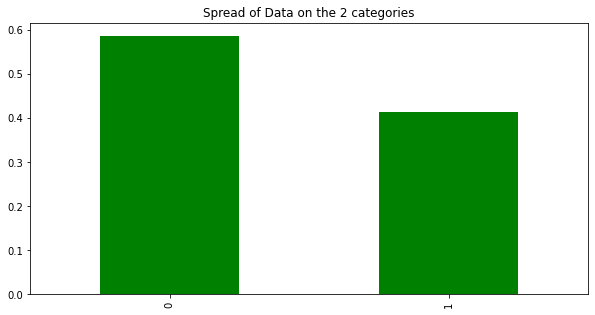

In [ ]:
(train_df.emergency_or_not.value_counts()/len(train_df) ).plot.bar(title= "Spread of Data on the 2 categories", figsize= (10, 5), color= "green");
train_df.emergency_or_not.value_counts()/len(train_df)

The training data is fairly balanced wrt information for each category.

# Transfer Learning Using Resnet50

##### Declaring Some Constants

In [ ]:
# Fixed for our  classes
NUM_CLASSES = 2

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

Adding Layers of model
1st layer of Resnet architechture and 2nd to train our data

In [ ]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Compile Our Transfer Learning Model

In [ ]:
from tensorflow.python.keras import optimizers

sgd = keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)


Prepare Keras Data Generators

Keras ImageDataGenerator(...) generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). It is useful with large dataset to source, pre-process (resize, color conversion, image augmentation, batch normalize) & supply resulting images in batches to downstream Keras modeling components, namely fit_generator(...) & predict_generator(...) -vs- fit(...) & predict(...) for small dataset.

In [ ]:
image_size = IMAGE_RESIZE

In [ ]:
# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_base_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_base_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 1333 images belonging to 2 classes.
Found 313 images belonging to 2 classes.


In [ ]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 14, 100, 4)

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/AV_CV2/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights('/content/drive/My Drive/AV_CV2/best.hdf5')

Epoch 1/10
14/14 [==============================] - 5s 379ms/step - loss: 0.0665 - accuracy: 0.9797 - val_loss: 0.1652 - val_accuracy: 0.9393
Epoch 2/10
14/14 [==============================] - 5s 380ms/step - loss: 0.0625 - accuracy: 0.9782 - val_loss: 0.1527 - val_accuracy: 0.9553
Epoch 3/10
14/14 [==============================] - 6s 416ms/step - loss: 0.0579 - accuracy: 0.9820 - val_loss: 0.1455 - val_accuracy: 0.9585
Epoch 4/10
14/14 [==============================] - 5s 388ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.1708 - val_accuracy: 0.9329
Epoch 5/10
14/14 [==============================] - 5s 392ms/step - loss: 0.0483 - accuracy: 0.9895 - val_loss: 0.1459 - val_accuracy: 0.9521
Epoch 6/10
14/14 [==============================] - 7s 488ms/step - loss: 0.0455 - accuracy: 0.9917 - val_loss: 0.1419 - val_accuracy: 0.9553
Epoch 7/10
14/14 [==============================] - 6s 432ms/step - loss: 0.0418 - accuracy: 0.9932 - val_loss: 0.1414 - val_accuracy: 0.9585
Epoch 

In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


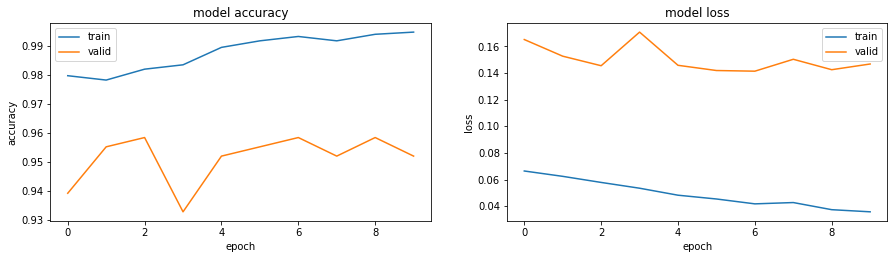

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = '/content/drive/My Drive/AV_CV2/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

# Try batch size of 1+ in test_generator & check batch_index & filenames in resulting batches
'''
for i in test_generator:
    #print(test_generator.batch_index, test_generator.batch_size)
    idx = (test_generator.batch_index - 1) * test_generator.batch_size
    print(test_generator.filenames[idx : idx + test_generator.batch_size])
'''

Found 706 images belonging to 1 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n'

In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
706/706 [==============================] - 201s 284ms/step


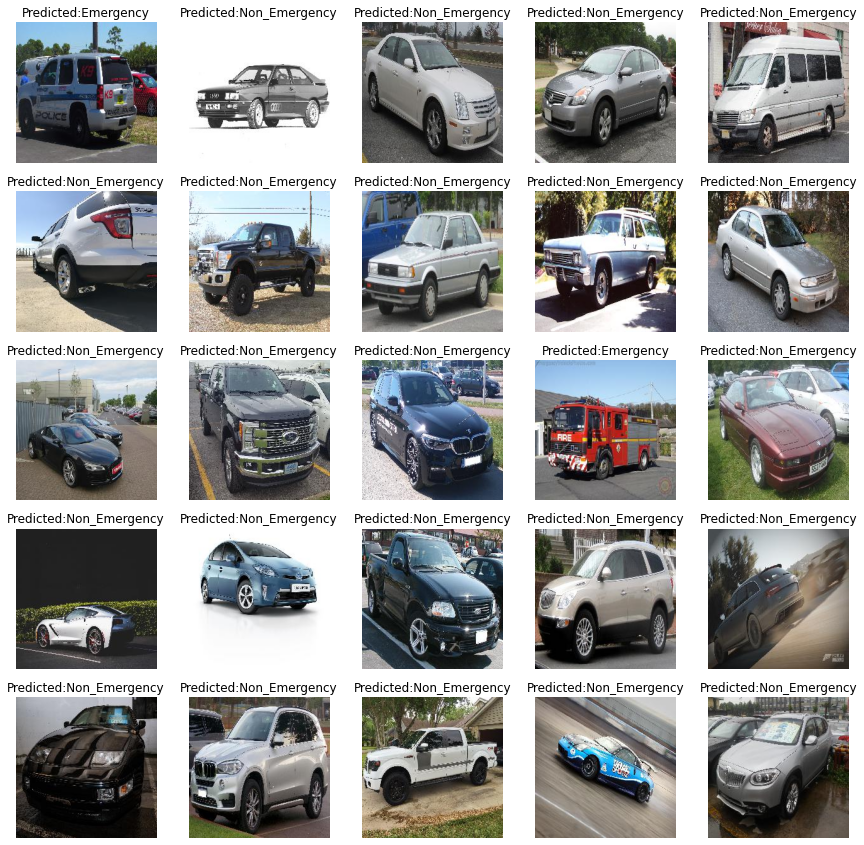

In [ ]:
TEST_DIR = '/content/drive/My Drive/AV_CV/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Non_Emergency" if predicted_class_indices[i] else "Emergency"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [ ]:
results_df = pd.DataFrame(
    {
        'image_names': pd.Series(test_generator.filenames), 
        'emergency_or_not': pd.Series(predicted_class_indices)
    })
results_df['image_names'] = results_df.image_names.replace('test/','',regex=True)
# results_df['image_names'] = pd.to_numeric(results_df['image_names'], errors = 'coerce')
results_df.sort_values(by='image_names', inplace = True)

results_df['emergency_or_not'] = 1-results_df['emergency_or_not']
results_df.to_csv('submission3_Team_Loop.csv', index=False)
results_df.head()

,image_names,emergency_or_not
0,100.jpg,1
1,1000.jpg,0
2,1001.jpg,0
3,1004.jpg,0
4,1014.jpg,0


# Building Model

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D,MaxPool2D,BatchNormalization,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
import tensorflow.keras.backend as K
from keras.callbacks import ReduceLROnPlateau

## Model through SVD

(Not used as it did not yield good result)

In [ ]:
'''# Data Preparation
def assign_label(img, veh_type):
    return veh_type

# SVD on images
def svd_func(img,K):
  U,S, V_t = np.linalg.svd(img[:,:,0])
  img1 = np.dot(U[:,:K],np.diag(S[:K])).dot(V_t[:K,:])
  U1,S1, V_t1 = np.linalg.svd(img[:,:,1])
  img2 = np.dot(U1[:,:K],np.diag(S1[:K])).dot(V_t1[:K,:])
  U2,S2, V_t2 = np.linalg.svd(img[:,:,2])
  img3 = np.dot(U2[:,:K],np.diag(S2[:K])).dot(V_t2[:K,:])
  img_recreated = np.zeros(shape=img.shape)
  im=np.dstack((img1,img2))
  constr_img = np.dstack((im,img3))
  constr_img = (constr_img - constr_img.min())/( constr_img.max()-  constr_img.min()) 
  return constr_img'''

In [ ]:
'''X=[]
Z=[]
K = 25
IMG_SIZE = 224
def make_train_data(veh_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,veh_type)
        path = os.path.join(DIR,img)
        img = plt.imread(path)
        svd_img = svd_func(img,K)
        res_img = cv2.resize(svd_img, (IMG_SIZE,IMG_SIZE))
        X.append(np.array(res_img))
        Z.append(str(label))

make_train_data('Emergency', f'{emergency_dir}/')
print(len(X))

make_train_data('Non-Emergency', f'{non_emergency_dir}/')
print(len(X))'''

In [ ]:
'''X_test=[]
Z_test=[]
K = 25
IMG_SIZE = 224
def make_validn_data(veh_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,veh_type)
        path = os.path.join(DIR,img)
        img = plt.imread(path)
        svd_img = svd_func(img,K)
        res_img = cv2.resize(svd_img, (IMG_SIZE,IMG_SIZE))
        X_test.append(np.array(res_img))
        Z_test.append(str(label))

make_validn_data('Emergency', f'{valid_base_dir}/emergency/')
print(len(X_test)

make_validn_data('Non-Emergency', f'{valid_base_dir}/non_emergency/')
print(len(X_test))'''

In [ ]:
'''fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Vehicle: '+Z[l])
        
plt.tight_layout()'''

In [ ]:
'''# Label Encoder
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
## The values of X are already between 0-1 so we dont need to divide it by 255

# Label Encoder
le=LabelEncoder()
Y_test= le.fit_transform(Z_test)
Y_test= to_categorical(Y_test, 2)
X_test= np.array(X_test)
## The values of X are already between 0-1 so we dont need to divide it by 255
'''

## Model through images directly

In [ ]:
# K.clear_session()

inp = Input(shape = (224, 224, 3),dtype = np.float32)
x = Conv2D(32,kernel_size = 3,activation = 'relu',padding = 'valid')(inp)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(64,kernel_size = 3,activation = 'relu',padding = 'valid')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(128,kernel_size = 3,activation = 'relu',padding = 'valid')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

out = Dense(2,activation = 'softmax')(x)
model = Model(inp,out)
model.summary()

In [ ]:
IMG_SIZE = 224
batch_size=128
epochs=50

STEPS_PER_EPOCH_TRAINING = train_df.shape[0]* .80// batch_size
STEPS_PER_EPOCH_VALIDATION = train_df.shape[0]* .20// batch_size


# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [ ]:
es = EarlyStopping(monitor='loss', patience = 20)
rlr = ReduceLROnPlateau(factor = 0.5)
chk_pts = ModelCheckpoint(monitor = 'loss', save_best_only=True,filepath='best_mode')

In [ ]:
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(x_train)
#test_datagen = ImageDataGenerator(rescale=1. / 255)
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_base_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_base_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
'''History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)'''

History= model.fit(train_generator, steps_per_epoch= STEPS_PER_EPOCH_TRAINING, epochs=epochs, 
                   batch_size=batch_size,validation_data = validation_generator,
                   validation_steps= STEPS_PER_EPOCH_VALIDATION, callbacks=[chk_pts, es] )

In [ ]:
History.history.keys()

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# getting predictions on validation set.
pred= model.predict(x_test)
pred_digits= np.argmax(pred, axis=1)